In [4]:
import mne
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view as sliding
import pandas as pd
import os
from scipy import signal
from matplotlib import pyplot as plt

# What is this file

It contains a pipeline to process our raw Unicorn recordings into a format suitable for the TinySleepNet model. It takes all CSV files in a directory, processes them and saves NPZ files one after another. These files are ready to give to the `predict.py` of TinySleepNet (other config files are needed for them to be loaded correctly).

# Main info

TiniSleepNet uses the Fpz-Cz channel for predictions. That means, the informative channel is Fpz and the reference is Cz.

Unicorn does not provide Fpz channel. Fpz-Cz is unavailable for us.

The other channel in the training data is Pz-Oz. We can use it instead.

So, we need to re-train the TiniSleepNet on this channel (done).

In [5]:
def open_unicorn_csv(path, unicorn_ch_names):
    df = pd.read_csv(path)
    df = df.rename(columns=dict(zip([f'EEG {i}' for i in range(1, 9)], unicorn_ch_names)))
    return df


def rereferencing(df):
    Pz_Oz = df['Pz'] - df['Oz']
    return Pz_Oz


def selecting_good_amplitude(channel, sample_rate_ratio, max_amplitude, segment_min_length):
    cut_segments = np.split(channel, channel[np.abs(channel) > max_amplitude].index.to_numpy())
    good_data = [x[1:] for x in cut_segments if len(x)>=segment_min_length * sample_rate_ratio + 1]

    lens = [len(x) for x in good_data]
    print(f'There are {len(good_data)} segments with length from {min(lens)} to {max(lens)} points')
    print(f'Highest amplitude: {max([max(x) for x in good_data])} uV')
    return good_data


def resampling_segments(old_segments, old_sample_rate, new_sample_rate):
    segments = [signal.resample(x, round(len(x)/old_sample_rate*new_sample_rate)) 
                for x in old_segments]
    lens = [len(x) for x in segments]
    print(f'Resampled segments are with length from {min(lens)} to {max(lens)} points')
    return segments


def cutting_into_fixed_segments(segments, length, start_each):
    X = []
    for segment in segments:
        for i in range(len(segment) // start_each):
            X.append(segment[i * start_each : i * start_each + length])
    X = [x for x in X if len(x) == length]
    print(f'Got {len(X)} segments with length of {length} points each')
    return X


def plot_random_segments(segments):
    rand = np.random.choice(range(len(segments)), size=9, replace=False)

    fig, axs = plt.subplots(3, 3, figsize=(10, 10), sharey=True, sharex=True)
    for i, ax in enumerate(axs.ravel()):
        ax.plot(segments[rand[i]])    
    plt.show()
    
    
def save_segments_for_tinysleep(X, file_duration, sample_rate, epoch_duration, filename):
    save_dict = {
        "x": np.array(X), 
        "y": np.array([0] * len(X)), 
        "fs": sample_rate,
        "ch_label": 'EEG Pz-Oz',
        "start_datetime": 'none',
        "file_duration": file_duration,
        "epoch_duration": epoch_duration,
        "n_all_epochs": len(X),
        "n_epochs": len(X),
    }
    np.savez(filename, **save_dict)
    
def save_real_segments(segments, filename):
    np.savez(filename, x=segments)

In [8]:
def run_pipeline_on_file(path, unicorn_ch_names, sample_rate, new_sample_rate, epoch_len, max_amplitude, new_path):
    df = open_unicorn_csv(path, unicorn_ch_names)
    channel = rereferencing(df)
    segments = selecting_good_amplitude(channel, sample_rate_ratio=sample_rate/new_sample_rate, max_amplitude=max_amplitude,
                                        segment_min_length=epoch_len*new_sample_rate)
    segments = cutting_into_fixed_segments(segments, length=sample_rate*epoch_len, start_each=sample_rate*epoch_len//2)
    X = resampling_segments(segments, old_sample_rate=sample_rate, new_sample_rate=new_sample_rate)
    plot_random_segments(X)
    save_segments_for_tinysleep(X, file_duration=len(df) // sample_rate, 
                                sample_rate=new_sample_rate, epoch_duration=epoch_len, 
                                filename=new_path)
    save_real_segments(segments, filename=new_path[:-4] + '_250hz.npz')
    
    
def run_pipelines(dir_path, save_dir_path, unicorn_ch_names, sample_rate, new_sample_rate, epoch_len, max_amplitude):
    paths = os.listdir(dir_path)
    for path in paths:
        old_path = os.path.join(dir_path, path)
        new_path = os.path.join(save_dir_path, ''.join(path[:-4].rsplit('_', 1)) + '.npz')
        run_pipeline_on_file(old_path, unicorn_ch_names, sample_rate=sample_rate, new_sample_rate=new_sample_rate, 
                         epoch_len=epoch_len, max_amplitude=max_amplitude, new_path=new_path)
    

There are 37 segments with length from 8023 to 342679 points
Highest amplitude: 99.92999999999998 uV
Got 673 segments with length of 7500 points each
Resampled segments are with length from 3000 to 3000 points


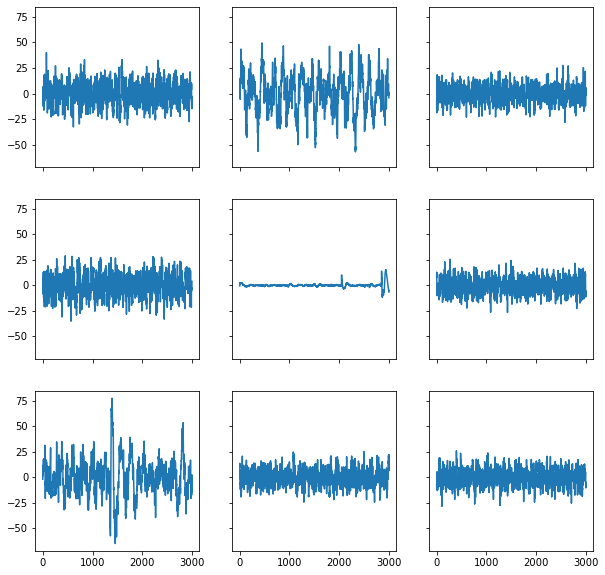

There are 18 segments with length from 7816 to 42430 points
Highest amplitude: 99.825 uV
Got 39 segments with length of 7500 points each
Resampled segments are with length from 3000 to 3000 points


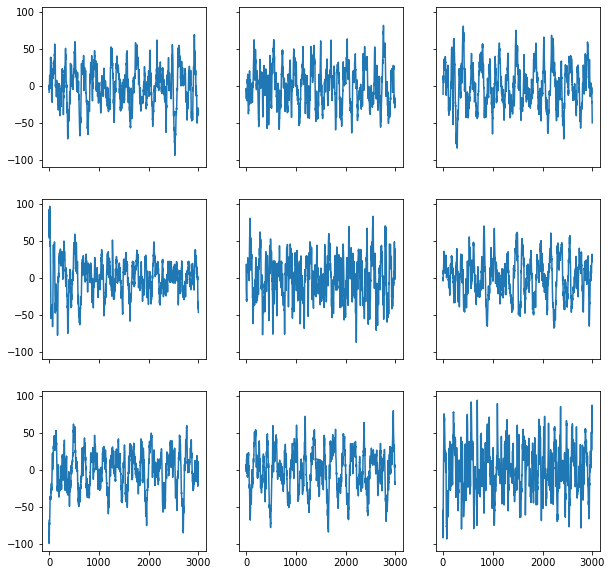

There are 50 segments with length from 8110 to 142523 points
Highest amplitude: 99.98100000000001 uV
Got 438 segments with length of 7500 points each
Resampled segments are with length from 3000 to 3000 points


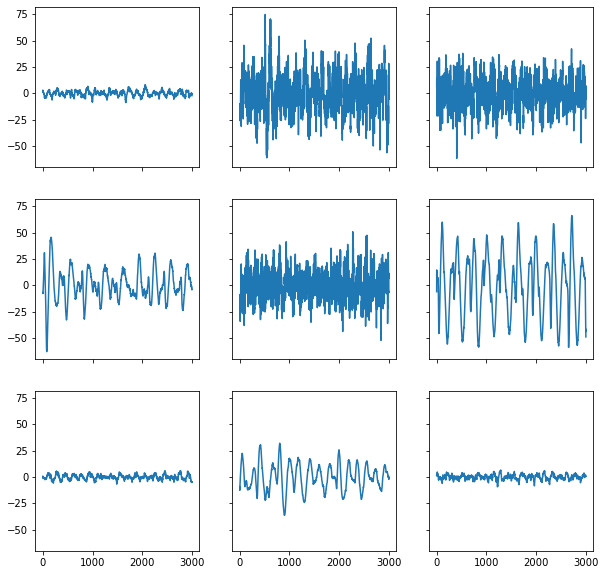

There are 68 segments with length from 7531 to 66998 points
Highest amplitude: 99.98400000000001 uV
Got 220 segments with length of 7500 points each
Resampled segments are with length from 3000 to 3000 points


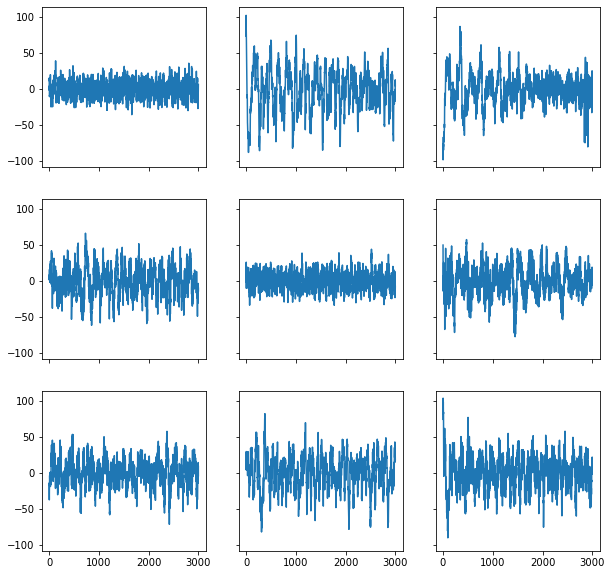

There are 43 segments with length from 8407 to 81642 points
Highest amplitude: 99.96000000000001 uV
Got 236 segments with length of 7500 points each
Resampled segments are with length from 3000 to 3000 points


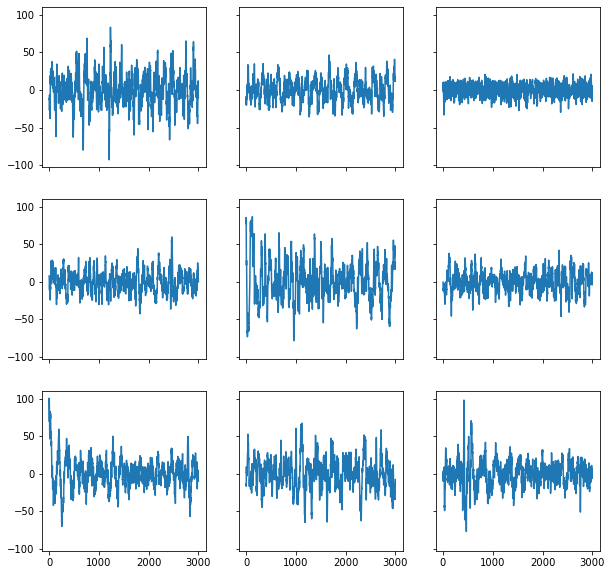

There are 67 segments with length from 7560 to 61710 points
Highest amplitude: 99.915 uV
Got 303 segments with length of 7500 points each
Resampled segments are with length from 3000 to 3000 points


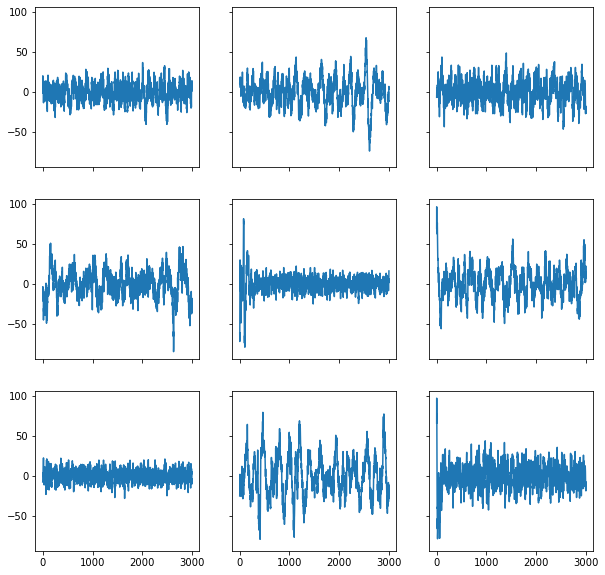

There are 87 segments with length from 7867 to 103201 points
Highest amplitude: 99.974 uV
Got 394 segments with length of 7500 points each
Resampled segments are with length from 3000 to 3000 points


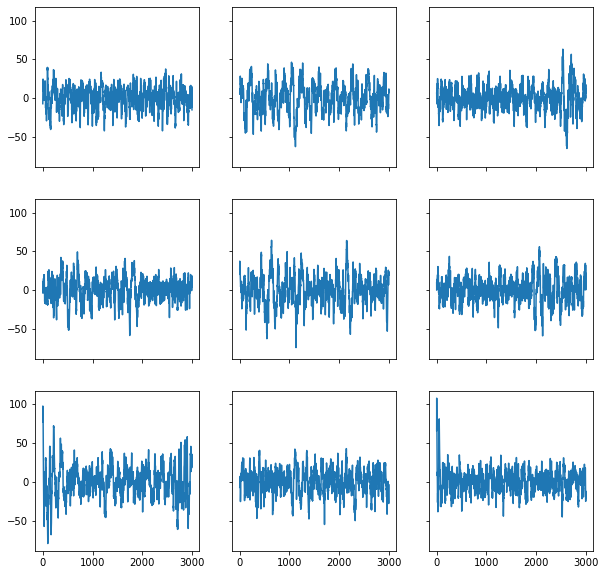

There are 49 segments with length from 8123 to 106559 points
Highest amplitude: 99.979 uV
Got 202 segments with length of 7500 points each
Resampled segments are with length from 3000 to 3000 points


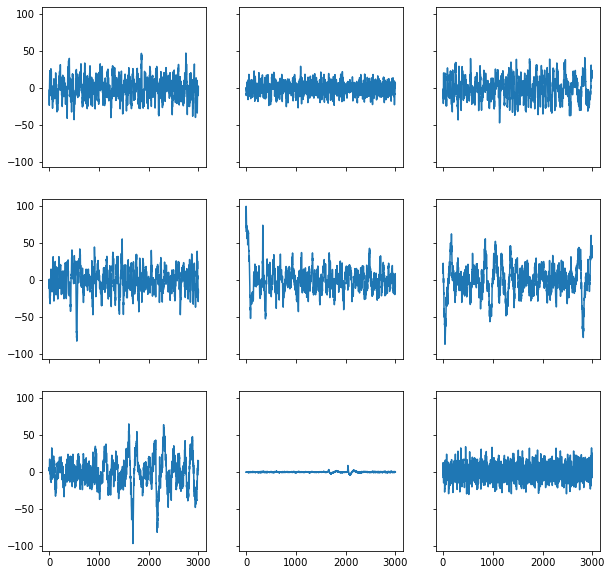

There are 43 segments with length from 7641 to 140401 points
Highest amplitude: 99.941 uV
Got 299 segments with length of 7500 points each
Resampled segments are with length from 3000 to 3000 points


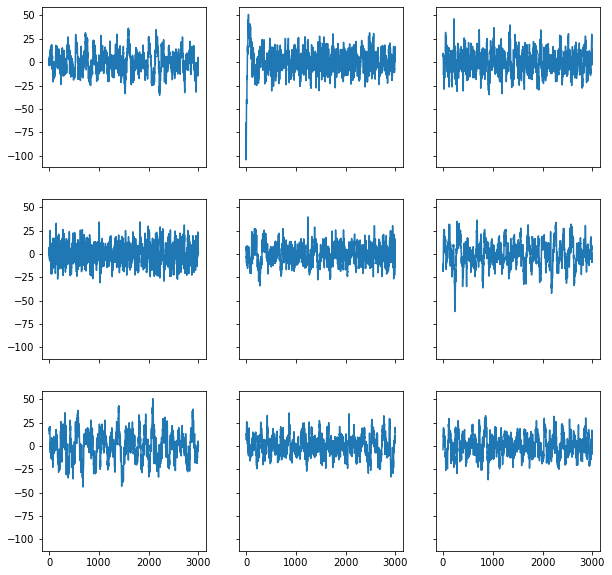

There are 51 segments with length from 7848 to 178789 points
Highest amplitude: 99.996 uV
Got 446 segments with length of 7500 points each
Resampled segments are with length from 3000 to 3000 points


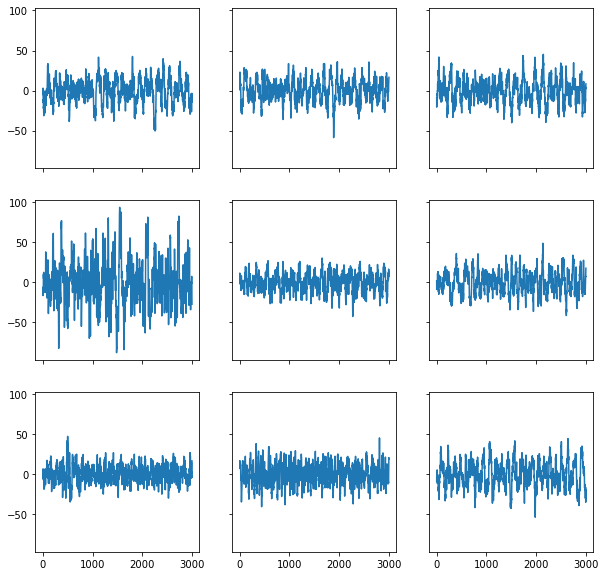

There are 47 segments with length from 7885 to 115702 points
Highest amplitude: 99.95700000000001 uV
Got 341 segments with length of 7500 points each
Resampled segments are with length from 3000 to 3000 points


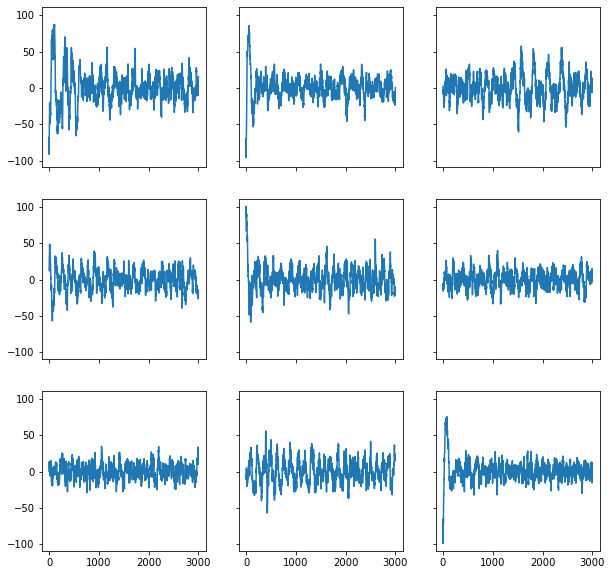

There are 18 segments with length from 7660 to 284319 points
Highest amplitude: 98.85999999999999 uV
Got 132 segments with length of 7500 points each
Resampled segments are with length from 3000 to 3000 points


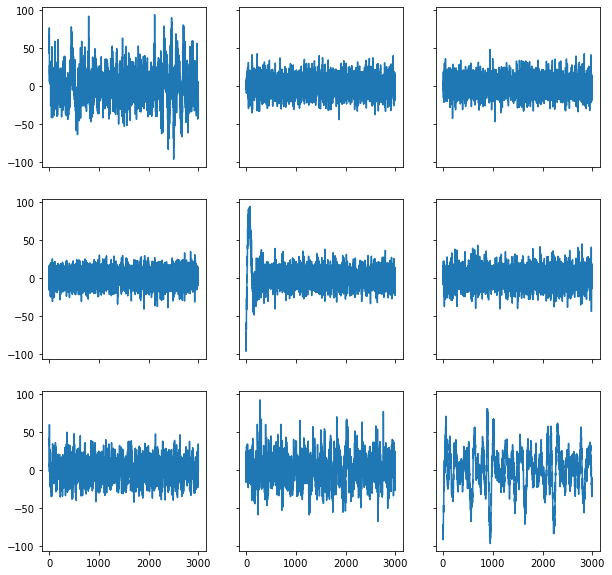

There are 43 segments with length from 7831 to 199934 points
Highest amplitude: 99.967 uV
Got 277 segments with length of 7500 points each
Resampled segments are with length from 3000 to 3000 points


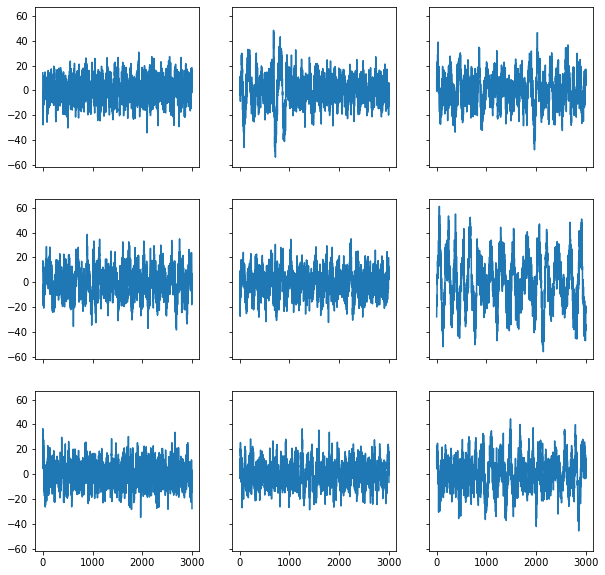

In [9]:
unicorn_ch_names = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']

run_pipelines('data/unicorncsv', 'data/unicornnpz', unicorn_ch_names, 
              sample_rate=250, new_sample_rate=100, epoch_len=30, max_amplitude=100)

# Extract segments after prediction

In [16]:
npz_files = os.listdir('data/unicornnpz')
rem_segments = {}
for npz in npz_files:
    print(npz)
    pred_filename = npz.rsplit('_', 1)[0] + '.npz' if '_250hz' in npz else npz
    pred_file = os.path.join('out_sleepedf/predict', 'pred_' + pred_filename)
    preds = np.load(pred_file)['y_pred']
    rem_idx = np.argwhere(preds == 4)
    
    segments = np.load(os.path.join('data/unicornnpz', npz))['x']
    rem_segments[npz[:-4]] = segments[rem_idx]

UnicornRecorder_20220721063315.npz
UnicornRecorder_20220721063315_250hz.npz
UnicornRecorder_20220722060903.npz
UnicornRecorder_20220722060903_250hz.npz
UnicornRecorder_20220723061244.npz
UnicornRecorder_20220723061244_250hz.npz
UnicornRecorder_20220725061639.npz
UnicornRecorder_20220725061639_250hz.npz
UnicornRecorder_20220726051734.npz
UnicornRecorder_20220726051734_250hz.npz
UnicornRecorder_20220727061055.npz
UnicornRecorder_20220727061055_250hz.npz
UnicornRecorder_20220728061723.npz
UnicornRecorder_20220728061723_250hz.npz
UnicornRecorder_20220729061646.npz
UnicornRecorder_20220729061646_250hz.npz
UnicornRecorder_20220730054628.npz
UnicornRecorder_20220730054628_250hz.npz
UnicornRecorder_20220731060149.npz
UnicornRecorder_20220731060149_250hz.npz
UnicornRecorder_20220801052037.npz
UnicornRecorder_20220801052037_250hz.npz
UnicornRecorder_20220804052912.npz
UnicornRecorder_20220804052912_250hz.npz
UnicornRecorder_20220805051454.npz
UnicornRecorder_20220805051454_250hz.npz


In [17]:
s100hz = {}
s250hz = {}
for key, value in rem_segments.items():
    print(f'{key}: {len(value)}')
    if '_250hz' in key:
        s250hz[key] = value
    else:
        s100hz[key] = value

UnicornRecorder_20220721063315: 4
UnicornRecorder_20220721063315_250hz: 4
UnicornRecorder_20220722060903: 0
UnicornRecorder_20220722060903_250hz: 0
UnicornRecorder_20220723061244: 153
UnicornRecorder_20220723061244_250hz: 153
UnicornRecorder_20220725061639: 30
UnicornRecorder_20220725061639_250hz: 30
UnicornRecorder_20220726051734: 54
UnicornRecorder_20220726051734_250hz: 54
UnicornRecorder_20220727061055: 53
UnicornRecorder_20220727061055_250hz: 53
UnicornRecorder_20220728061723: 137
UnicornRecorder_20220728061723_250hz: 137
UnicornRecorder_20220729061646: 41
UnicornRecorder_20220729061646_250hz: 41
UnicornRecorder_20220730054628: 124
UnicornRecorder_20220730054628_250hz: 124
UnicornRecorder_20220731060149: 31
UnicornRecorder_20220731060149_250hz: 31
UnicornRecorder_20220801052037: 141
UnicornRecorder_20220801052037_250hz: 141
UnicornRecorder_20220804052912: 0
UnicornRecorder_20220804052912_250hz: 0
UnicornRecorder_20220805051454: 0
UnicornRecorder_20220805051454_250hz: 0


In [18]:
len(s100hz), len(s250hz)

(13, 13)

In [19]:
np.savez("rem_segments.npz", **s100hz)
np.savez("rem_segments_250hz.npz", **s250hz)